In [183]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [184]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


추후 Feature Enginnering에 이용될 계산 함수 정의

In [185]:
###### ACC
# 가속도 벡터 magnitude
def calculate_mag(acc_x, acc_y, acc_z):
    acc_mag = np.sqrt(acc_x ** 2 + acc_y ** 2 + acc_z ** 2)
    return acc_mag

###### Activity bouts
def exercisepts(acc, hr, time): #acc and hr must be same length
    
    exercisepoints = []
    for z in range(len(acc)):
        if acc.iloc[z] > np.mean(acc.iloc[0:z]):
            if hr.iloc[z] > np.mean(hr.iloc[0:z]):
                exercisepoints.append(1)
            else:
                exercisepoints.append(0)
        else:
            exercisepoints.append(0)
            
    returndf = pd.DataFrame()
    returndf['datetime'] = time
    returndf['Activity Bouts'] = exercisepoints
    
    countbouts = len(exercisepoints)
    return countbouts, returndf

###### EDA
def peak_eda(eda):
    peaks_idx, properties = find_peaks(eda, height=0, distance=4, prominence=0.3)
    peak_eda = len(peaks_idx)
    return peak_eda

# PersHigh, PersLow, PersNorm 분류 함수
def classify_glucose(value, mean, std):
    if value > mean + std:
        return 'PersHigh'
    elif value < mean - std:
        return 'PersLow'
    else:
        return 'PersNorm'
    
###### IBI
def nn50(ibi):
    differences = abs(np.diff(ibi))
    n = np.sum(differences > 50)
    nn50 = round(n,1)
    return nn50

def pnn50(ibi):
    differences = abs(np.diff(ibi))
    n = np.sum(differences > 50)
    p=0
    if len(differences) != 0:
        p = (n / len(differences)) * 100
    pnn50 = round(p, 1)
    return pnn50

def rmssd(ibi):
    differences = abs(np.diff(ibi))
    rmssd = 0
    if len(differences) != 0:
        rmssd = np.sqrt(np.sum(np.square(differences)) / len(differences))
    rmssd = round(rmssd,1)
    return rmssd

def sdnn(ibi):
    if ibi.isnull().any():
        return np.nan
    #return round(np.sqrt(np.var(ibi, ddof=1)) * 10) / 10
    return round(np.sqrt(np.var(ibi, ddof=1)), 1)


## EXTENDED HRV FEATURES

def sdsd(ibi):
    if len(ibi) < 2:
        return np.nan
    return np.std(np.diff(ibi))

def cvnn(ibi):
    if len(ibi) == 0 or ibi.isnull().any() or sdnn(ibi) == 0 or np.isnan(sdnn(ibi)):
        return np.nan
    return np.mean(ibi) / sdnn(ibi)

def cvsd(ibi):
    if len(ibi) == 0 or ibi.isnull().any() or np.isnan(np.mean(ibi)):
        return np.nan
    return sdsd(ibi) / np.mean(ibi)

def mcvnn(ibi):
    if len(ibi) < 2 or ibi.isnull().any():
        return np.nan
    differences = abs(np.diff(ibi))
    return np.median(np.abs(differences - np.median(differences)))

def iqrnn(ibi):
    if len(ibi) == 0 or ibi.isnull().any():
        return np.nan
    return np.percentile(ibi, 75) - np.percentile(ibi, 25)

def sdrmssd(ibi):
    if len(ibi) == 0 or ibi.isnull().any() or rmssd(ibi) == 0 or np.isnan(rmssd(ibi)) or sdnn(ibi) == 0 or np.isnan(sdnn(ibi)):
        return np.nan
    return sdnn(ibi) / rmssd(ibi)

def prc20nn(ibi):
    if len(ibi) == 0:
        return np.nan
    return np.percentile(ibi, 20)

def prc80nn(ibi):
    if len(ibi) == 0:
        return np.nan
    return np.percentile(ibi, 80)

def tinn(ibi):
    if len(ibi) == 0:
        return np.nan
    hist, bin_edges = np.histogram(ibi, bins='auto')
    return bin_edges[-1] - bin_edges[0]

def hti(ibi):
    if len(ibi) == 0 or ibi.isnull().any():
        return np.nan
    hist, _ = np.histogram(ibi, bins='auto')
    if max(hist) == 0:
        return np.nan
    return max(hist)



###### circaidan rhythm
def crhythm(time, timeformat='%Y-%m-%d %H:%M:%S'):
    
    df = pd.DataFrame()
    df['Time'] =  pd.to_datetime(time, format=timeformat)
    df['Timefrommidnight'] =  df['Time'].dt.time
    hourfrommid=[]
    minfrommid=[]
    
    for i in range(0, len(df['Timefrommidnight'])):
        if pd.isna(df['Timefrommidnight'].iloc[i]):
            minfrommid.append(0)
            hourfrommid.append(0)
        else:
            minfrommid.append(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[0:2])*60 + int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[3:5]) + round(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[6:9])/60))
            hourfrommid.append(round((int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[0:2])*60 + int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[3:5]) + round(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[6:9])/60))/60))

    return hourfrommid, minfrommid


# Wake Time을 감지하는 함수를 정의합니다.
'''
def detect_wake_time(df, slope_threshold = 0.5):
    wake_times = pd.Series(0, index=df.index)
    for current_time in df.index:
        past_time = current_time - pd.Timedelta(minutes=75)
        if past_time < df.index[0]:  # 시작 시간 이전이면 무시
            continue
        else:
            closest_past_time = df.index.asof(past_time)
            slope = (df.loc[current_time, 'Rolling_HR_Mean'] - df.loc[closest_past_time, 'Rolling_HR_Mean']) / 15 # / 75
            if slope > slope_threshold:
                wake_times.loc[current_time] = 1
    return wake_times
'''

def detect_wake_time(processed_data, short_window=25, long_window=75):
    # Identifying wake time
    wake_times = pd.Series(0, index=processed_data.index)
    unique_days = processed_data.index.normalize().unique()

    for day in unique_days:
        day_data = processed_data[processed_data.index.normalize() == day]
        if not day_data.empty:
            smoothed_binary = day_data['rolling_avg']
            start_time = day_data.index[0]
            end_time = day_data.index[-1]
            
            
            idx = 0
            current_time = day_data.index[idx]
            while current_time + pd.Timedelta(minutes=long_window) <= end_time:
                short_term_window_end = current_time + pd.Timedelta(minutes=short_window)
                long_term_window_end = current_time + pd.Timedelta(minutes=long_window)

                rolling_slope = processed_data.loc[current_time, 'rolling_slope']

                if np.abs(rolling_slope) > 0 and all(smoothed_binary.loc[short_term_window_end:long_term_window_end] > smoothed_binary.loc[current_time]):
                    wake_times.loc[current_time] = 1
                    #break

                idx += 1  # Move the window by one minute
                current_time = day_data.index[idx]

    return wake_times



def MAGE(df, std=1):
    """
        Computes and returns the mean amplitude of glucose excursions
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
        Returns:
            MAGE (float): the mean amplitude of glucose excursions 
        Refs:
            Sneh Gajiwala: https://github.com/snehG0205/NCSA_genomics/tree/2bfbb87c9c872b1458ef3597d9fb2e56ac13ad64
            
    """
        
    #extracting glucose values and incdices
    glucose = df['glucose'].tolist()
    ix = [1*i for i in range(len(glucose))]
    stdev = std
    
    # local minima & maxima
    a = np.diff(np.sign(np.diff(glucose))).nonzero()[0] + 1      
    # local min
    valleys = (np.diff(np.sign(np.diff(glucose))) > 0).nonzero()[0] + 1 
    # local max
    peaks = (np.diff(np.sign(np.diff(glucose))) < 0).nonzero()[0] + 1         
    # +1 -- diff reduces original index number

    #store local minima and maxima -> identify + remove turning points
    excursion_points = pd.DataFrame(columns=['Index', 'time', 'glucose', 'type'])
    k=0
    for i in range(len(peaks)):
        excursion_points.loc[k] = [peaks[i]] + [df['time'].iloc[k]] + [df['glucose'].iloc[k]] + ["P"]
        k+=1

    for i in range(len(valleys)):
        excursion_points.loc[k] = [valleys[i]] + [df['time'].iloc[k]] + [df['glucose'].iloc[k]] + ["V"]
        k+=1

    excursion_points = excursion_points.sort_values(by=['Index'])
    excursion_points = excursion_points.reset_index(drop=True)


    # selecting turning points
    turning_points = pd.DataFrame(columns=['Index', 'time', 'glucose', 'type'])
    k=0
    for i in range(stdev,len(excursion_points.Index)-stdev):
        positions = [i-stdev,i,i+stdev]
        for j in range(0,len(positions)-1):
            if(excursion_points.type[positions[j]] == excursion_points.type[positions[j+1]]):
                if(excursion_points.type[positions[j]]=='P'):
                    if excursion_points.glucose[positions[j]]>=excursion_points.glucose[positions[j+1]]:
                        turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                        k+=1
                    else:
                        turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                        k+=1
                else:
                    if excursion_points.glucose[positions[j]]<=excursion_points.glucose[positions[j+1]]:
                        turning_points.loc[k] = excursion_points.loc[positions[j]]
                        k+=1
                    else:
                        turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                        k+=1

    if len(turning_points.index)<10:
        turning_points = excursion_points.copy()
        excursion_count = len(excursion_points.index)
    else:
        excursion_count = len(excursion_points.index)/2


    turning_points = turning_points.drop_duplicates(subset= "Index", keep= "first")
    turning_points=turning_points.reset_index(drop=True)
    excursion_points = excursion_points[excursion_points.Index.isin(turning_points.Index) == False]
    excursion_points = excursion_points.reset_index(drop=True)

    # calculating MAGE
    mage = turning_points.glucose.sum()/excursion_count
    
    return round(mage,3)

In [186]:
# 빈 DataFrame 생성
df = pd.DataFrame(columns=[
    'calories2hr',
    'protein2hr',
    'sugar2hr',
    'carbs2hr',
    'calories8hr',
    'protein8hr',
    'sugar8hr',
    'carbs8hr',
    'calories24hr',
    'protein24hr',
    'sugar24hr',
    'carbs24hr',
    'eat',
    'eatcnt2hr',
    'eatcnt8hr',
    'eatcnt24hr',
    'eatmean2hr',
    'eatmean8hr',
    'eatmean24hr',
    'acc_mean',
    'acc_std',
    'acc_min',
    'acc_max',
    'acc_q1g',
    'acc_q3g',
    'acc_skew',
    'acc_mean_2hrs',
    'acc_max_2hrs',
    'eda_mean',
    'eda_std',
    'eda_min',
    'eda_max',
    'eda_q1g',
    'eda_q3g',
    'eda_skew',
    'PeakEDA',
    'PeakEDA2hr_sum',
    'PeakEDA2hr_mean',
    'hr_mean',
    'hr_std',
    'hr_min',
    'hr_max',
    'hr_q1g',
    'hr_q3g',
    'hr_skew',
    'maxHRV',
    'minHRV',
    'medianHRV',
    'meanHRV',
    'SDNN',
    'NN50',
    'pNN50',
    'RMSSD',
    'SDSD', #
    'CVNN', #
    'MCVNN', #
    'SDRMSSD', #
    'TINN', #
    #'HTI',
    'temp_mean',
    'temp_std',
    'temp_min',
    'temp_max',
    'temp_q1g',
    'temp_q3g',
    'temp_skew',
    'Activity_bouts',
    'Activity24',
    'Activity1hr',
    'Minfrommid',
    'Hourfrommid',
    'carbs2hr_ratio',
    'protein2hr_ratio',
    'sugar2hr_ratio',
    'elapsed_minutes_intake',
])

## Warnings

* 003 데이터셋 Food_Log에 칼럼 누락되어 있음 추가 필요 (단, time_end 칼럼은 없어야 하며, 뒷부분의 4개 칼럼은 {calorie,total_carb,sugar,protein}으로 구성됨).
* 001 데이터셋의 HR 대해서 datetime 포맷이 다름 (hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')).
* 012 데이터셋 Food_Log의 마지막 행에 데이터 누락됨.
    ~~~
    2020-05-11,07:00:00,,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    -> 2020-05-11,07:00:00,2020-05-11 07:00:00,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    ~~~
* 013 데이터셋 Food_Log의 date와 datetime 포맷이 다름.

## 중요 Warnings - 처리한 불일치 문제

7번 참가자 Food log 날짜가 일치하지 않음.  
  
덱스콤 실제 데이터 범위  
2020-03-14 12:42:19  
2020-03-22 11:06:57  
  
Food Log  
10/16/2019 13:44  
10/24/2019 8:30  
  
-----------------------------------------------
12번 참가자 5월 3일, 4일 데이터가 포함되지 않음.
  
-----------------------------------------------
13번 참가자 Food log 날짜가 일치하지 않음.  
  
덱스콤 활용 데이터 범위. 5일  
Start: 2020-05-30 15:41:50  
End: 2020-06-04 12:11:40  
  
Food Log 범위. 8일  
12/30/2019 16:30  
1/6/2020 9:30  
  
-----------------------------------------------
15번 참가자 Food log 날짜가 범위에서 벗어남.  
  
덱스콤 활용 데이터 범위.  
Start: 2020-07-21 22:28:52  
End: 2020-07-25 11:33:48  
  
덱스콤 실제 데이터 범위.  
2020-07-19 17:33:52  
2020-07-27 10:38:46  
  
Food Log  
2020-02-17 10:00:00  
2020-02-25 07:30:00  

In [187]:
def validate_daily_dfs(daily_dfs):
    diff_set = set()
    accset = set()
    edaset = set()
    hrset = set()
    ibiset = set()
    tempset = set()
    dexcomset = set()
    for idx in range(len(daily_dfs['acc'])):
        accset = accset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['acc'][idx].index.date))
    for idx in range(len(daily_dfs['eda'])):
        edaset = edaset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['eda'][idx].index.date))
    for idx in range(len(daily_dfs['hr'])):
        hrset = hrset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['hr'][idx].index.date))
    for idx in range(len(daily_dfs['ibi'])):
        ibiset = ibiset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['ibi'][idx].index.date))
    for idx in range(len(daily_dfs['temp'])):
        tempset = tempset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['temp'][idx].index.date))
    for idx in range(len(daily_dfs['dexcom'])):
        dexcomset = dexcomset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['dexcom'][idx].index.date))
    ## 차집합 연산 : 하나라도 예외적인 다른 날짜가 있다면 제외시켜야 함.
    diff_set = diff_set.union(dexcomset.difference(accset))
    diff_set = diff_set.union(dexcomset.difference(edaset))
    diff_set = diff_set.union(dexcomset.difference(hrset))
    diff_set = diff_set.union(dexcomset.difference(ibiset))
    diff_set = diff_set.union(dexcomset.difference(tempset))
    print(f'Exclude date: {diff_set}')

    if len(diff_set) > 0:
        ## diffset의 date값을 갖고 있는 daily_dfs 딕셔너리 내 value 의 리스트 원소(데이터프레임)를 제거
        if len(diff_set & accset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['acc'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['acc'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['acc'] = [daily_dfs['acc'][i] for i in range(len(daily_dfs['acc'])) if i not in indexes_to_remove]

        if len(diff_set & edaset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['eda'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['eda'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['eda'] = [daily_dfs['eda'][i] for i in range(len(daily_dfs['eda'])) if i not in indexes_to_remove]

        if len(diff_set & hrset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['hr'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['hr'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['hr'] = [daily_dfs['hr'][i] for i in range(len(daily_dfs['hr'])) if i not in indexes_to_remove]

        if len(diff_set & ibiset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['ibi'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['ibi'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['ibi'] = [daily_dfs['ibi'][i] for i in range(len(daily_dfs['ibi'])) if i not in indexes_to_remove]

        if len(diff_set & tempset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['temp'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['temp'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['temp'] = [daily_dfs['temp'][i] for i in range(len(daily_dfs['temp'])) if i not in indexes_to_remove]
        
        if len(diff_set & dexcomset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['dexcom'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['dexcom'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['dexcom'] = [daily_dfs['dexcom'][i] for i in range(len(daily_dfs['dexcom'])) if i not in indexes_to_remove]

        return False, daily_dfs
    return True, daily_dfs

24시간 윈도우

In [188]:
exclude_first24hr = False # 첫 24시간 데이터를 포함할 것인지 제외할 것인지.
ibimultiplier = 1000 # Transform ibi to milliseconds

In [189]:
for id in range(1, len(dg_df)+1):
    if id == 15: # Skip ID 15
        continue
    fl_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Food_Log_{id:03}.csv')
    acc_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/ACC_{id:03}.csv')
    eda_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/EDA_{id:03}.csv')
    #bvp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/BVP_{id:03}.csv')
    hr_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/HR_{id:03}.csv')
    ibi_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/IBI_{id:03}.csv')
    temp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/TEMP_{id:03}.csv')
    dexcom_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Dexcom_{id:03}.csv')

    biological_sex = dg_df.loc[dg_df['ID'] == id, 'Gender'].values[0]
    hbA1c = dg_df.loc[dg_df['ID'] == id, 'HbA1c'].values[0]

    print(f'[ID: {id}] Now processing ...')

    ## datetime 변환 및 리샘플링 전처리
    ## Dexcom Gluecose
    dexcom_df.drop(dexcom_df.loc[:11].index, inplace=True)
    dexcom_df.rename(columns = {'Timestamp (YYYY-MM-DDThh:mm:ss)': 'datetime'}, inplace = True)
    dexcom_df.rename(columns = {'Glucose Value (mg/dL)': 'glucose'}, inplace = True)
    dexcom_df = dexcom_df[['datetime', 'glucose']]
    dexcom_df['datetime']=pd.to_datetime(dexcom_df['datetime'])
    dexcom_df.set_index('datetime', inplace=True)

    ## Food Log
    if id == 13:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'], format='%m/%d/%Y %H:%M')
    else:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'])


    ## Food Log 시간 범위 조정 - 불일치 문제 해결
    if id == 7:
        new_start = pd.Timestamp("2020-03-14 13:44:00")
        old_start = pd.Timestamp("2019-10-16 13:44:00")
        # 시간 차이 계산
        time_difference = new_start - old_start
        # 시간 범위 조정
        fl_df['time_begin'] = fl_df['time_begin'] + time_difference
    elif id == 13:
        new_start = pd.Timestamp("2020-05-28 16:30:00")
        old_start = pd.Timestamp("2019-12-30 16:30:00")
        # 시간 차이 계산
        time_difference = new_start - old_start
        # 시간 범위 조정
        fl_df['time_begin'] = fl_df['time_begin'] + time_difference
    elif id == 16:
        new_start = pd.Timestamp("2020-07-17 06:30:00")
        old_start = pd.Timestamp("2020-02-21 06:30:00")
        # 시간 차이 계산
        time_difference = new_start - old_start
        # 시간 범위 조정
        fl_df['time_begin'] = fl_df['time_begin'] + time_difference
        # 2020-07-17일 이전의 데이터 자르기 - Food Log 부재
        cutoff_date = pd.Timestamp('2020-07-17')
        dexcom_df = dexcom_df[dexcom_df.index >= cutoff_date]
    
        
    fl_df.index = pd.DatetimeIndex(fl_df["time_begin"])
    fl_df = fl_df.sort_index()
    
    ## Accelerometer
    acc_df['datetime']=pd.to_datetime(acc_df['datetime'])
    acc_df['vector_mag'] = calculate_mag(acc_df[' acc_x'], acc_df[' acc_y'], acc_df[' acc_z'])
    acc_df.drop(columns=[' acc_x', ' acc_y', ' acc_z'], inplace=True)
    acc_resampled = pd.DataFrame()
    acc_resampled['ACC_Mean'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').mean().interpolate(method='time')
    acc_resampled['ACC_Std'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').std().interpolate(method='time')
    acc_resampled['ACC_Min'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').min().interpolate(method='time')
    acc_resampled['ACC_Max'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').max().interpolate(method='time')
    acc_resampled['ACC_Q1G'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').quantile(0.25).interpolate(method='time')
    acc_resampled['ACC_Q3G'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').quantile(0.75).interpolate(method='time')
    acc_resampled['ACC_Skew'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').apply(lambda x: x.skew()).interpolate(method='time')
    
    ## EDA
    eda_df['datetime']=pd.to_datetime(eda_df['datetime'])
    eda_resampled = pd.DataFrame()
    eda_resampled['EDA_Mean'] = eda_df.set_index('datetime')[' eda'].resample('5Min').mean().interpolate(method='time')
    eda_resampled['EDA_Std'] = eda_df.set_index('datetime')[' eda'].resample('5Min').std().interpolate(method='time')
    eda_resampled['EDA_Min'] = eda_df.set_index('datetime')[' eda'].resample('5Min').min().interpolate(method='time')
    eda_resampled['EDA_Max'] = eda_df.set_index('datetime')[' eda'].resample('5Min').max().interpolate(method='time')
    eda_resampled['EDA_Q1G'] = eda_df.set_index('datetime')[' eda'].resample('5Min').quantile(0.25).interpolate(method='time')
    eda_resampled['EDA_Q3G'] = eda_df.set_index('datetime')[' eda'].resample('5Min').quantile(0.75).interpolate(method='time')
    eda_resampled['EDA_Skew'] = eda_df.set_index('datetime')[' eda'].resample('5Min').apply(lambda eda: eda.skew()).interpolate(method='time')
    eda_resampled['peakEDA'] = eda_df.set_index('datetime')[' eda'].resample('5Min').apply(lambda eda: peak_eda(eda)).interpolate(method='time')
    ## Heart Rate
    if id == 1:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')
    else:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'])
    hr_resampled = pd.DataFrame()
    hr_resampled['HR_Mean'] = hr_df.set_index('datetime')[' hr'].resample('5Min').mean().interpolate(method='time')
    hr_resampled['HR_Std'] = hr_df.set_index('datetime')[' hr'].resample('5Min').std().interpolate(method='time')
    hr_resampled['HR_Min'] = hr_df.set_index('datetime')[' hr'].resample('5Min').min().interpolate(method='time')
    hr_resampled['HR_Max'] = hr_df.set_index('datetime')[' hr'].resample('5Min').max().interpolate(method='time')
    hr_resampled['HR_Q1G'] = hr_df.set_index('datetime')[' hr'].resample('5Min').quantile(0.25).interpolate(method='time')
    hr_resampled['HR_Q3G'] = hr_df.set_index('datetime')[' hr'].resample('5Min').quantile(0.75).interpolate(method='time')
    hr_resampled['HR_Skew'] = hr_df.set_index('datetime')[' hr'].resample('5Min').apply(lambda hr: hr.skew()).interpolate(method='time')
    
    ## Temperature
    temp_df['datetime']=pd.to_datetime(temp_df['datetime'])
    temp_resampled = pd.DataFrame()
    temp_resampled['TEMP_Mean'] = temp_df.set_index('datetime')[' temp'].resample('5Min').mean().interpolate(method='time')
    temp_resampled['TEMP_Std'] = temp_df.set_index('datetime')[' temp'].resample('5Min').std().interpolate(method='time')
    temp_resampled['TEMP_Min'] = temp_df.set_index('datetime')[' temp'].resample('5Min').min().interpolate(method='time')
    temp_resampled['TEMP_Max'] = temp_df.set_index('datetime')[' temp'].resample('5Min').max().interpolate(method='time')
    temp_resampled['TEMP_Q1G'] = temp_df.set_index('datetime')[' temp'].resample('5Min').quantile(0.25).interpolate(method='time')
    temp_resampled['TEMP_Q3G'] = temp_df.set_index('datetime')[' temp'].resample('5Min').quantile(0.75).interpolate(method='time')
    temp_resampled['TEMP_Skew'] = temp_df.set_index('datetime')[' temp'].resample('5Min').apply(lambda temp: temp.skew()).interpolate(method='time')
    
    ## IBI
    ibi_df['datetime']=pd.to_datetime(ibi_df['datetime'])
    #ibi_df[' ibi'] = ibi_df[' ibi'].interpolate(method='time')
    ibi_df[' ibi'] = ibi_df[' ibi'] * ibimultiplier # 초 -> 밀리초 단위로
    #ibi_resampled = ibi_df.set_index('datetime').resample('5Min').first().interpolate(method='time')
    ibi_resampled = pd.DataFrame()
    ibi_resampled['minHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').min().interpolate(method='time')
    ibi_resampled['maxHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').max().interpolate(method='time')
    ibi_resampled['medianHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').median().interpolate(method='time')
    ibi_resampled['meanHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').mean().interpolate(method='time')
    ibi_resampled['SDNN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: sdnn(ibi)).interpolate(method='time')
    ibi_resampled['NN50'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: nn50(ibi)).interpolate(method='time')
    ibi_resampled['pNN50'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: pnn50(ibi)).interpolate(method='time')
    ibi_resampled['RMSSD'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: rmssd(ibi)).interpolate(method='time')
    
    ibi_resampled['SDSD'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: sdsd(ibi)).interpolate(method='time')
    ibi_resampled['CVNN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: cvnn(ibi)).interpolate(method='time')
    ibi_resampled['CVSD'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: cvsd(ibi)).interpolate(method='time')
    ibi_resampled['MCVNN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: mcvnn(ibi)).interpolate(method='time')
    # ibi_resampled['IQRNN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: iqrnn(ibi)).interpolate(method='time')
    ibi_resampled['SDRMSSD'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: sdrmssd(ibi)).interpolate(method='time')
    #ibi_resampled['Prc20NN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: prc20nn(ibi)).interpolate(method='time')
    #ibi_resampled['Prc80NN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: prc80nn(ibi)).interpolate(method='time')
    ibi_resampled['TINN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: tinn(ibi)).interpolate(method='time')
    #ibi_resampled['HTI'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: hti(ibi)).interpolate(method='time')

    ## 날짜를 기준으로 데이터프레임을 분할하여 리스트에 저장
    daily_dfs = {'fl':[], 'acc':[], 'eda':[], 'hr':[], 'ibi':[], 'temp':[], 'bvp':[], 'dexcom':[]}
    for name, group in dexcom_df.groupby(dexcom_df.index.date):
        daily_dfs['dexcom'].append(group)
    for name, group in fl_df.groupby(fl_df['time_begin'].dt.date):
        daily_dfs['fl'].append(group)
    for name, group in acc_resampled.groupby(acc_resampled.index.date):
        daily_dfs['acc'].append(group)
    for name, group in eda_resampled.groupby(eda_resampled.index.date):
        daily_dfs['eda'].append(group)
    for name, group in hr_resampled.groupby(hr_resampled.index.date):
        daily_dfs['hr'].append(group)
    for name, group in ibi_resampled.groupby(ibi_resampled.index.date):
        daily_dfs['ibi'].append(group)
    for name, group in temp_resampled.groupby(temp_resampled.index.date):
        daily_dfs['temp'].append(group)

    isok, daily_dfs = validate_daily_dfs(daily_dfs=daily_dfs)
    if isok == False:
        print(f'daily_dfs is modified...')
        
    base_df = pd.concat(daily_dfs['dexcom'])
    
    ## *_df 이름의 데이터프레임으로 리뉴얼

    acc_df.drop(acc_df.index, inplace=True)
    eda_df.drop(eda_df.index, inplace=True)
    hr_df.drop(hr_df.index, inplace=True)
    ibi_df.drop(ibi_df.index, inplace=True)
    temp_df.drop(temp_df.index, inplace=True)

    if len(daily_dfs['acc']) > 0:
        acc_df = pd.concat(daily_dfs['acc'])
    if len(daily_dfs['eda']) > 0:
        eda_df = pd.concat(daily_dfs['eda'])
    if len(daily_dfs['hr']) > 0:   
        hr_df = pd.concat(daily_dfs['hr'])
    if len(daily_dfs['ibi']) > 0:
        ibi_df = pd.concat(daily_dfs['ibi'])
    if len(daily_dfs['temp']) > 0:
        temp_df = pd.concat(daily_dfs['temp'])
    
    ###### activitybouts
    print(f'len acc == hr : {len(acc_df) == len(hr_df)}')
    if len(acc_df) != len(hr_df):
        print(f"acc : {acc_df.index[0].strftime('%Y-%m-%d %H:%M:%S')} ~ {acc_df.index[-1].strftime('%Y-%m-%d %H:%M:%S')} : {len(acc_df)}")
        print(f"hr : {hr_df.index[0].strftime('%Y-%m-%d %H:%M:%S')} ~ {hr_df.index[-1].strftime('%Y-%m-%d %H:%M:%S')} : {len(hr_df)}")
        # Get the intersection of the indices
        common_index = acc_df.index.intersection(hr_df.index)
        # Filter both dataframes to only include the common indices
        acc_df = acc_df.loc[common_index]
        hr_df = hr_df.loc[common_index]
        print(f'After preprocessing-> len acc == hr : {len(acc_df) == len(hr_df)}')

    resultlen , returndf = exercisepts(acc_df['ACC_Mean'], hr_df['HR_Mean'], acc_df.index)
    acc_df['Activity_bouts'] = returndf['Activity Bouts'].values


    ## 윈도우 크기 설정
    window_size = '24h'

    if exclude_first24hr:
        base_df = base_df.loc[base_df.index[0] + pd.Timedelta('24h'):] ## 24.07.19 - 첫 24시간은 대상에서 제외 (CGM이 첫날은 부정확)

    ## 각 타임스탬프에 대해 24시간 롤링 윈도우를 계산
    for timestamp in base_df.index:
        window_start = timestamp - pd.Timedelta(window_size)
        window_end = timestamp 
        
        if window_start < base_df.index[0]:
            continue
        elif window_start >= base_df.index[0] and window_start < base_df.index[1]:
            print(f"[ID: {id}] window_start: {window_start.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"[ID: {id}] window_end: {window_end.strftime('%Y-%m-%d %H:%M:%S')}")

        # df_glucose의 롤링 윈도우 범위 내의 데이터 선택
        glucose_window = base_df.loc[window_start:window_end]
        
        # df_other의 동일한 범위 내의 데이터 선택
        fl_window = fl_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        acc_window = acc_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        eda_window = eda_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        hr_window = hr_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        ibi_window = ibi_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        temp_window = temp_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        
        # glucose_window를 명시적으로 복사본으로 생성
        for_mage = glucose_window.copy()

        # 복사본 데이터프레임에서 작업
        for_mage['time'] = glucose_window.index
        #print(f'MAGE: {MAGE(for_mage)}')


        ##### Wake Time
        # 1. 현재 값이 Historical 평균보다 작은지 확인
        hr_historical = hr_window
        acc_historical = acc_window
        hr_mean_avg = hr_historical['HR_Mean'].mean()
        hr_std_avg = hr_historical['HR_Std'].mean()
        acc_mean_avg = acc_historical['ACC_Mean'].mean()
        acc_std_avg = acc_historical['ACC_Std'].mean()
        

        # 해당 날짜의 데이터 필터링 및 평균 계산
        '''
        specific_date = timestamp.date()
        hr_daily = hr_df[hr_df.index.date == specific_date]
        acc_daily = acc_df[hr_df.index.date == specific_date]
        
        hr_mean_avg = hr_daily.loc[:window_end]['HR_Mean'].mean()
        hr_std_avg = hr_daily.loc[:window_end]['HR_Std'].mean()
        acc_mean_avg = acc_daily.loc[:window_end]['ACC_Mean'].mean()
        acc_std_avg = acc_daily.loc[:window_end]['ACC_Std'].mean()
        '''
        
        base_df.loc[window_end, 'points'] = (
            (hr_window.iloc[-1]['HR_Mean'] < hr_mean_avg).astype(int) +
            (hr_window.iloc[-1]['HR_Std'] < hr_std_avg).astype(int) +
            (acc_window.iloc[-1]['ACC_Mean'] < acc_mean_avg).astype(int) +
            (acc_window.iloc[-1]['ACC_Std'] < acc_std_avg).astype(int)
        ) # 하루의 평균보다 작은 것의 개수

        # 2. 하루의 평균보다 작은 것의 개수가 2보다 크면 0 값을 할당합니다.
        base_df.loc[window_end, 'binary'] = (base_df.loc[window_end, 'points'] < 2).astype(int)

        # 3시간 동안의 데이터를 이동 평균(rolling)으로 계산합니다.
        # 데이터가 5분 간격이라고 가정하면, 3시간은 36 interval입니다.
        rolling_window3hr = base_df.loc[window_end - pd.Timedelta('3hr'):window_end]
        base_df.loc[window_end, 'rolling_avg'] = rolling_window3hr['binary'].mean()
        base_df.loc[window_end, 'Rolling_HR_Mean'] = hr_df.loc[window_end - pd.Timedelta('3hr'):window_end]['HR_Mean'].mean()
        

        ##### fl

        calories2hr = 0.
        protein2hr = 0.
        sugar2hr = 0.
        carbs2hr = 0.
        calories8hr = 0.
        protein8hr = 0.
        sugar8hr = 0.
        carbs8hr = 0.
        calories24hr = 0.
        protein24hr = 0.
        sugar24hr = 0.
        carbs24hr = 0.
        
        flwindow5min = fl_window[window_end - pd.Timedelta('5m') : window_end]# - pd.Timedelta('5m')]
        flwindow2hr = fl_window[window_end - pd.Timedelta('2h') : window_end]# - pd.Timedelta('5m')]
        flwindow8hr = fl_window[window_end - pd.Timedelta('8h') : window_end]# - pd.Timedelta('5m')]
        flwindow24hr = fl_window[window_end - pd.Timedelta('24h') : window_end]# - pd.Timedelta('5m')]

        eat = 0
        if len(flwindow5min) > 0:
            eat = 1
        eatcnt2hr = len(flwindow2hr)
        eatcnt8hr = len(flwindow8hr)
        eatcnt24hr = len(flwindow24hr)

        eatmean2hr = eatcnt2hr / (2 * 60 / 5)  # 2시간 동안 5분 간격으로 나눈 시간 간격 수
        eatmean8hr = eatcnt8hr / (8 * 60 / 5)  # 8시간 동안 5분 간격으로 나눈 시간 간격 수
        eatmean24hr = eatcnt24hr / (24 * 60 / 5)  # 24시간 동안 5분 간격으로 나눈 시간 간격 수
        
        calories2hr = flwindow2hr['calorie'].values.sum()
        protein2hr = flwindow2hr['protein'].values.sum()
        sugar2hr = flwindow2hr['sugar'].values.sum()
        carbs2hr = flwindow2hr['total_carb'].values.sum()
        
        calories8hr = flwindow8hr['calorie'].values.sum()
        protein8hr = flwindow8hr['protein'].values.sum()
        sugar8hr = flwindow8hr['sugar'].values.sum()
        carbs8hr = flwindow8hr['total_carb'].values.sum()
        
        calories24hr = fl_window['calorie'].values.sum()
        protein24hr = fl_window['protein'].values.sum()
        sugar24hr = fl_window['sugar'].values.sum()
        carbs24hr = fl_window['total_carb'].values.sum()


        carbs2hr_ratio = 0.
        protein2hr_ratio = 0.
        sugar2hr_ratio = 0.
        if (round(carbs2hr,2) + round(protein2hr,2) + round(sugar2hr,2)) != 0:
            carbs2hr_ratio = round(round(carbs2hr,2)/(round(carbs2hr,2) + round(protein2hr,2) + round(sugar2hr,2)), 2)
            protein2hr_ratio = round(round(protein2hr,2)/(round(carbs2hr,2) + round(protein2hr,2) + round(sugar2hr,2)), 2)
            sugar2hr_ratio = round(round(sugar2hr,2)/(round(carbs2hr,2) + round(protein2hr,2) + round(sugar2hr,2)), 2)
        
        elapsed_minutes = (window_end - window_start).total_seconds() / 60
        if len(flwindow24hr) > 0:
            last_intake = flwindow24hr.last()['time_begin']
            elapsed_time = window_end - last_intake
        # 분 단위로 변환
        elapsed_minutes = elapsed_time.total_seconds() / 60
        
        ###### acc
        accwindow2hr = acc_window[window_end - pd.Timedelta('2h') : window_end]# - pd.Timedelta('5m')]
        accwindow1hr = acc_window[window_end - pd.Timedelta('1h') : window_end]# - pd.Timedelta('5m')]

        acc_mean_2hrs = accwindow2hr['ACC_Mean'].values.mean()
        acc_max_2hrs = accwindow2hr['ACC_Max'].values.max()

        activity24 = acc_window['Activity_bouts'].values.mean()
        activity1hr = accwindow1hr['Activity_bouts'].values.sum()

        ###### eda

        # peak detection
        edawindow2hr = eda_window[window_end - pd.Timedelta('2h') : window_end]# - pd.Timedelta('5m')]

        peakEDA2hr_sum = edawindow2hr['peakEDA'].values.sum()
        peakEDA2hr_mean = edawindow2hr['peakEDA'].values.mean()

        ##### results
        #print(f"(end of window): {window_end}, glucose: {glucose_window['glucose']}, sugar24hr: {sugar24hr}")
        # df_glucose의 개인화된 평균 및 표준 편차 계산 -> Class를 나누는 값 계산
        #print(f"[{window_start.strftime('%Y-%m-%d %H:%M:%S')} ~ {window_end.strftime('%Y-%m-%d %H:%M:%S')}] ID: {id}, sugar24hr: {sugar24hr}, glucose: {base_df.loc[window_end, 'glucose']}")
        base_df.loc[window_end, 'datetime'] = window_end.strftime('%Y-%m-%d %H:%M:%S')
        base_df.loc[window_end, 'personalMean'] = glucose_window['glucose'].mean()
        base_df.loc[window_end, 'personalStd'] = glucose_window['glucose'].std()
        base_df.loc[window_end, 'MAGE'] = MAGE(for_mage)
        base_df.loc[window_end, 'ID']=id
        base_df.loc[window_end, 'HbA1c']=hbA1c
        base_df.loc[window_end, 'Biological Sex']=biological_sex
        base_df.loc[window_end, 'calories2hr']=round(calories2hr,2)
        base_df.loc[window_end, 'protein2hr']=round(protein2hr,2)
        base_df.loc[window_end, 'sugar2hr']=round(sugar2hr,2)
        base_df.loc[window_end, 'carbs2hr']=round(carbs2hr,2)
        base_df.loc[window_end, 'calories8hr']=round(calories8hr,2)
        base_df.loc[window_end, 'protein8hr']=round(protein8hr,2)
        base_df.loc[window_end, 'sugar8hr']=round(sugar8hr,2)
        base_df.loc[window_end, 'carbs8hr']=round(carbs8hr,2)
        base_df.loc[window_end, 'calories24hr']=round(calories24hr,2)
        base_df.loc[window_end, 'protein24hr']=round(protein24hr,2)
        base_df.loc[window_end, 'sugar24hr']=round(sugar24hr,2)
        base_df.loc[window_end, 'carbs24hr']=round(carbs24hr,2)
        base_df.loc[window_end, 'eat']=eat
        base_df.loc[window_end, 'eatcnt2hr']=round(eatcnt2hr,2)
        base_df.loc[window_end, 'eatcnt8hr']=round(eatcnt8hr,2)
        base_df.loc[window_end, 'eatcnt24hr']=round(eatcnt24hr,2)
        base_df.loc[window_end, 'eatmean2hr']=round(eatmean2hr,2)
        base_df.loc[window_end, 'eatmean8hr']=round(eatmean8hr,2)
        base_df.loc[window_end, 'eatmean24hr']=round(eatmean24hr,2)
        base_df.loc[window_end, 'acc_mean']=round(acc_window.iloc[-1]['ACC_Mean'],2)
        base_df.loc[window_end, 'acc_std']=round(acc_window.iloc[-1]['ACC_Std'],2)
        base_df.loc[window_end, 'acc_min']=round(acc_window.iloc[-1]['ACC_Min'],2)
        base_df.loc[window_end, 'acc_max']=round(acc_window.iloc[-1]['ACC_Max'],2)
        base_df.loc[window_end, 'acc_q1g']=round(acc_window.iloc[-1]['ACC_Q1G'],2)
        base_df.loc[window_end, 'acc_q3g']=round(acc_window.iloc[-1]['ACC_Q3G'],2)
        base_df.loc[window_end, 'acc_skew']=round(acc_window.iloc[-1]['ACC_Skew'],2)
        base_df.loc[window_end, 'acc_mean_2hrs']=round(acc_mean_2hrs,2)
        base_df.loc[window_end, 'acc_max_2hrs']=round(acc_max_2hrs,2)
        base_df.loc[window_end, 'eda_mean']=round(eda_window.iloc[-1]['EDA_Mean'],2)
        base_df.loc[window_end, 'eda_std']=round(eda_window.iloc[-1]['EDA_Std'],2)
        base_df.loc[window_end, 'eda_min']=round(eda_window.iloc[-1]['EDA_Min'],2)
        base_df.loc[window_end, 'eda_max']=round(eda_window.iloc[-1]['EDA_Max'],2)
        base_df.loc[window_end, 'eda_q1g']=round(eda_window.iloc[-1]['EDA_Q1G'],2)
        base_df.loc[window_end, 'eda_q3g']=round(eda_window.iloc[-1]['EDA_Q3G'],2)
        base_df.loc[window_end, 'eda_skew']=round(eda_window.iloc[-1]['EDA_Skew'],2)
        base_df.loc[window_end, 'PeakEDA']=eda_window.iloc[-1]['peakEDA']
        base_df.loc[window_end, 'PeakEDA2hr_sum']=round(peakEDA2hr_sum,2)
        base_df.loc[window_end, 'PeakEDA2hr_mean']=round(peakEDA2hr_mean,2)
        base_df.loc[window_end, 'hr_mean']=round(hr_window.iloc[-1]['HR_Mean'],2)
        base_df.loc[window_end, 'hr_std']=round(hr_window.iloc[-1]['HR_Std'],2)
        base_df.loc[window_end, 'hr_min']=round(hr_window.iloc[-1]['HR_Min'],2)
        base_df.loc[window_end, 'hr_max']=round(hr_window.iloc[-1]['HR_Max'],2)
        base_df.loc[window_end, 'hr_q1g']=round(hr_window.iloc[-1]['HR_Q1G'],2)
        base_df.loc[window_end, 'hr_q3g']=round(hr_window.iloc[-1]['HR_Q3G'],2)
        base_df.loc[window_end, 'hr_skew']=round(hr_window.iloc[-1]['HR_Skew'],2)
        base_df.loc[window_end, 'maxHRV']=round(ibi_window.iloc[-1]['maxHRV'],2)
        base_df.loc[window_end, 'minHRV']=round(ibi_window.iloc[-1]['minHRV'],2)
        base_df.loc[window_end, 'medianHRV']=round(ibi_window.iloc[-1]['medianHRV'],2)
        base_df.loc[window_end, 'meanHRV']=round(ibi_window.iloc[-1]['meanHRV'],2)
        base_df.loc[window_end, 'SDNN']=round(ibi_window.iloc[-1]['SDNN'],2)
        base_df.loc[window_end, 'NN50']=round(ibi_window.iloc[-1]['NN50'],2)
        base_df.loc[window_end, 'pNN50']=round(ibi_window.iloc[-1]['pNN50'],2)
        base_df.loc[window_end, 'RMSSD']=round(ibi_window.iloc[-1]['RMSSD'],2)
        base_df.loc[window_end, 'SDSD']=round(ibi_window.iloc[-1]['SDSD'],2)
        base_df.loc[window_end, 'CVNN']=round(ibi_window.iloc[-1]['CVNN'],2)
        base_df.loc[window_end, 'CVSD']=round(ibi_window.iloc[-1]['CVSD'],2)
        base_df.loc[window_end, 'MCVNN']=round(ibi_window.iloc[-1]['MCVNN'],2)
        base_df.loc[window_end, 'SDRMSSD']=round(ibi_window.iloc[-1]['SDRMSSD'],2)
        base_df.loc[window_end, 'TINN']=round(ibi_window.iloc[-1]['TINN'],2)
        base_df.loc[window_end, 'temp_mean']=round(temp_window.iloc[-1]['TEMP_Mean'],2)
        base_df.loc[window_end, 'temp_std']=round(temp_window.iloc[-1]['TEMP_Std'],2)
        base_df.loc[window_end, 'temp_min']=round(temp_window.iloc[-1]['TEMP_Min'],2)
        base_df.loc[window_end, 'temp_max']=round(temp_window.iloc[-1]['TEMP_Max'],2)
        base_df.loc[window_end, 'temp_q1g']=round(temp_window.iloc[-1]['TEMP_Q1G'],2)
        base_df.loc[window_end, 'temp_q3g']=round(temp_window.iloc[-1]['TEMP_Q3G'],2)
        base_df.loc[window_end, 'temp_skew']=round(temp_window.iloc[-1]['TEMP_Skew'],2)
        base_df.loc[window_end, 'Activity_bouts']=acc_window.iloc[-1]['Activity_bouts']
        base_df.loc[window_end, 'Activity24']=activity24
        base_df.loc[window_end, 'Activity1hr']=activity1hr
        base_df.loc[window_end, 'carbs2hr_ratio']=carbs2hr_ratio
        base_df.loc[window_end, 'protein2hr_ratio']=protein2hr_ratio
        base_df.loc[window_end, 'sugar2hr_ratio']=sugar2hr_ratio
        base_df.loc[window_end, 'elapsed_minutes_intake']=elapsed_minutes


    ###### crhythm
    hrfrommid, minfrommid = crhythm(base_df['datetime'])
    base_df['Minfrommid'] = minfrommid
    base_df['Hourfrommid'] = hrfrommid


    # rolling average의 기울기(slope)를 계산합니다.
    base_df['rolling_slope'] = base_df['rolling_avg'].diff()
    # 4. 'WakeTime' 칼럼에 값을 저장합니다.
    base_df['WakeTime'] = detect_wake_time(base_df)

    # WakeTime을 확인하기 위한 출력
    wake_time_indices = base_df[base_df['WakeTime'] == 1].index.strftime('%Y-%m-%d %H:%M:%S')
    wake_times_str = ', '.join(map(str, wake_time_indices))
    #print(wake_times_str)

    ###### 각 측정값을 PersHigh, PersLow, PersNorm으로 분류
    base_df['label'] = base_df.apply(
        lambda row: classify_glucose(row['glucose'], row['personalMean'], row['personalStd']), axis=1
    )

    base_df.drop(columns = ['points', 'binary', 'rolling_avg', 'Rolling_HR_Mean'], inplace = True)
    base_df.drop(columns=['personalMean', 'personalStd'], inplace=True)

    df = pd.concat([df, base_df], ignore_index=True)
    

[ID: 1] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 1] window_start: 2020-02-13 17:28:30
[ID: 1] window_end: 2020-02-14 17:28:30


/tmp/ipykernel_880/2538047428.py:462: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, base_df], ignore_index=True)


[ID: 2] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 2] window_start: 2020-02-21 11:13:34
[ID: 2] window_end: 2020-02-22 11:13:34
[ID: 3] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 3] window_start: 2020-02-22 10:51:44
[ID: 3] window_end: 2020-02-23 10:51:44
[ID: 4] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 4] window_start: 2020-02-27 11:01:19
[ID: 4] window_end: 2020-02-28 11:01:19
[ID: 5] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 5] window_start: 2020-02-27 13:40:09
[ID: 5] window_end: 2020-02-28 13:40:09
[ID: 6] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 6] window_start: 2020-02-28 12:23:11
[ID: 6] window_end: 2020-02-29 12:23:11
[ID: 7] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 7] window_start: 2020-03-14 12:52:15
[ID: 7] window_end: 2020-03-15 12:52:15
[ID: 8] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 8] window_start: 2020-03-14

/tmp/ipykernel_880/3252746584.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  turning_points.loc[k] = excursion_points.loc[positions[j+1]]
/tmp/ipykernel_880/3252746584.py:260: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  turning_points.loc[k] = excursion_points.loc[positions[j+1]]


[ID: 16] Now processing ...
Exclude date: {'2020-07-24'}
daily_dfs is modified...
len acc == hr : True
[ID: 16] window_start: 2020-07-17 00:08:22
[ID: 16] window_end: 2020-07-18 00:08:22


In [190]:
print(len(df))

34843


In [191]:
df[['SDSD',
    'CVNN',
    'MCVNN',
    'SDRMSSD',
    'TINN']].isna().sum()

SDSD       4315
CVNN       4315
MCVNN      4315
SDRMSSD    4315
TINN       4315
dtype: int64

In [192]:
df = df.dropna().reset_index(drop=True)

In [193]:
df[(df['WakeTime'] == 1) & (df['ID'] == 2)].head(30)

,calories2hr,protein2hr,sugar2hr,carbs2hr,calories8hr,protein8hr,sugar8hr,carbs8hr,calories24hr,protein24hr,...,glucose,datetime,MAGE,ID,HbA1c,Biological Sex,CVSD,rolling_slope,WakeTime,label
2273,0.0,0.0,0.0,0.0,410.0,13.0,66.0,83.0,3118.0,106.0,...,106.0,2020-02-22 11:28:34,58.028,2.0,5.6,MALE,0.11,-0.166667,1.0,PersLow
2274,0.0,0.0,0.0,0.0,410.0,13.0,66.0,83.0,3118.0,106.0,...,106.0,2020-02-22 11:33:34,57.699,2.0,5.6,MALE,0.09,0.100000,1.0,PersLow
2278,0.0,0.0,0.0,0.0,410.0,13.0,66.0,83.0,3118.0,106.0,...,105.0,2020-02-22 11:53:33,60.158,2.0,5.6,MALE,0.08,-0.083333,1.0,PersLow
2279,0.0,0.0,0.0,0.0,410.0,13.0,66.0,83.0,3118.0,106.0,...,105.0,2020-02-22 11:58:33,58.805,2.0,5.6,MALE,0.09,-0.066667,1.0,PersLow
2280,0.0,0.0,0.0,0.0,410.0,13.0,66.0,83.0,3118.0,106.0,...,105.0,2020-02-22 12:03:33,58.597,2.0,5.6,MALE,0.13,0.036364,1.0,PersLow
2281,0.0,0.0,0.0,0.0,410.0,13.0,66.0,83.0,3118.0,106.0,...,105.0,2020-02-22 12:08:35,58.182,2.0,5.6,MALE,0.12,0.030303,1.0,PersLow
2282,0.0,0.0,0.0,0.0,410.0,13.0,66.0,83.0,2870.0,93.0,...,106.0,2020-02-22 12:13:34,57.436,2.0,5.6,MALE,0.09,0.025641,1.0,PersLow
2283,0.0,0.0,0.0,0.0,410.0,13.0,66.0,83.0,2870.0,93.0,...,107.0,2020-02-22 12:18:33,57.436,2.0,5.6,MALE,0.25,0.021978,1.0,PersLow
2284,0.0,0.0,0.0,0.0,410.0,13.0,66.0,83.0,2870.0,93.0,...,107.0,2020-02-22 12:23:33,57.359,2.0,5.6,MALE,0.10,0.019048,1.0,PersLow
2285,0.0,0.0,0.0,0.0,410.0,13.0,66.0,83.0,2870.0,93.0,...,107.0,2020-02-22 12:28:34,57.077,2.0,5.6,MALE,0.06,0.016667,1.0,PersLow


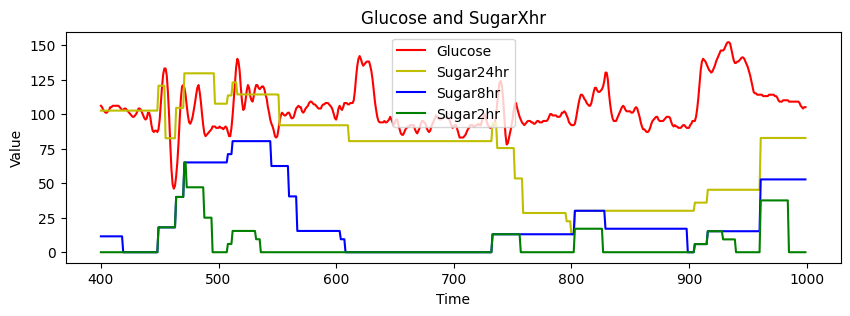

In [194]:
import matplotlib.pyplot as plt

# 날짜 필터링
filtered_df = df.iloc[400:1000]

# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(filtered_df.index, filtered_df['glucose'], 'r', label='Glucose')
plt.plot(filtered_df.index, filtered_df['sugar24hr'], 'y', label='Sugar24hr')
plt.plot(filtered_df.index, filtered_df['sugar8hr'], 'b', label='Sugar8hr')
plt.plot(filtered_df.index, filtered_df['sugar2hr'], 'g', label='Sugar2hr')

plt.title('Glucose and SugarXhr')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

### Feature Normalization

횟수 관련 features도 normalization이 필요할까? => 일단 현재에선 정규화 대상에서 제외함.

In [195]:
# 숫자형 feature 컬럼만 선택
feature_cols = df.select_dtypes(include=['number']).columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('glucose')
feature_cols.remove('MAGE')
feature_cols.remove('eat')
feature_cols.remove('eatcnt2hr')
feature_cols.remove('eatcnt8hr')
feature_cols.remove('eatcnt24hr')

if 'Biological Sex' in feature_cols:
    feature_cols.remove('Biological Sex')
if 'label' in feature_cols:
    feature_cols.remove('Biological Sex')
print(len(feature_cols))
print(feature_cols)

72
['calories2hr', 'protein2hr', 'sugar2hr', 'carbs2hr', 'calories8hr', 'protein8hr', 'sugar8hr', 'carbs8hr', 'calories24hr', 'protein24hr', 'sugar24hr', 'carbs24hr', 'eatmean2hr', 'eatmean8hr', 'eatmean24hr', 'acc_mean', 'acc_std', 'acc_min', 'acc_max', 'acc_q1g', 'acc_q3g', 'acc_skew', 'acc_mean_2hrs', 'acc_max_2hrs', 'eda_mean', 'eda_std', 'eda_min', 'eda_max', 'eda_q1g', 'eda_q3g', 'eda_skew', 'PeakEDA', 'PeakEDA2hr_sum', 'PeakEDA2hr_mean', 'hr_mean', 'hr_std', 'hr_min', 'hr_max', 'hr_q1g', 'hr_q3g', 'hr_skew', 'maxHRV', 'minHRV', 'medianHRV', 'meanHRV', 'SDNN', 'NN50', 'pNN50', 'RMSSD', 'SDSD', 'CVNN', 'MCVNN', 'SDRMSSD', 'TINN', 'temp_mean', 'temp_std', 'temp_min', 'temp_max', 'temp_q1g', 'temp_q3g', 'temp_skew', 'Activity_bouts', 'Activity24', 'Activity1hr', 'carbs2hr_ratio', 'protein2hr_ratio', 'sugar2hr_ratio', 'elapsed_minutes_intake', 'HbA1c', 'CVSD', 'rolling_slope', 'WakeTime']


In [196]:
# 사용자별 정규화를 수행하는 함수 정의
def user_specific_normalization(df, id_col, feature_cols):
    # 숫자형 feature 컬럼만 선택
    #feature_cols = df.select_dtypes(include=['number']).columns.tolist()
    if id_col in feature_cols:
        feature_cols.remove(id_col)
    
    # 결과를 저장할 데이터 프레임
    normalized_df = pd.DataFrame(columns=df.columns)
    
    # 각 사용자의 데이터를 정규화
    for user_id, group in df.groupby(id_col):
        scaler = StandardScaler()
        # features 부분만 정규화 수행
        normalized_features = scaler.fit_transform(group[feature_cols])
        normalized_group = pd.DataFrame(normalized_features, columns=feature_cols)
        # ID 컬럼과 범주형 컬럼 복사
        normalized_group[id_col] = user_id
        for col in df.columns:
            if col not in feature_cols and col != id_col:
                normalized_group[col] = group[col].values
        normalized_df = pd.concat([normalized_df, normalized_group], ignore_index=True)
    
    return normalized_df

# 사용자별 정규화 수행
normalized_df = user_specific_normalization(df, 'ID', feature_cols=feature_cols)

/tmp/ipykernel_880/3267098898.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  normalized_df = pd.concat([normalized_df, normalized_group], ignore_index=True)


In [197]:
normalized_df.head(10)

,calories2hr,protein2hr,sugar2hr,carbs2hr,calories8hr,protein8hr,sugar8hr,carbs8hr,calories24hr,protein24hr,...,glucose,datetime,MAGE,ID,HbA1c,Biological Sex,CVSD,rolling_slope,WakeTime,label
0,-0.559966,-0.452255,-0.478611,-0.512037,0.486363,-0.088403,0.080385,-0.351476,0.813356,1.725621,...,95.0,2020-02-14 17:33:30,43.152,1.0,0.0,FEMALE,1.060735,-24.266741,-0.424680,PersNorm
1,-0.559966,-0.452255,-0.478611,-0.512037,-0.306611,-0.294228,-0.742606,-0.942015,0.813356,1.725621,...,95.0,2020-02-14 17:38:30,43.475,1.0,0.0,FEMALE,1.397177,8.113577,-0.424680,PersNorm
2,-0.559966,-0.452255,-0.478611,-0.512037,-0.306611,-0.294228,-0.742606,-0.942015,0.813356,1.725621,...,95.0,2020-02-14 17:43:30,43.879,1.0,0.0,FEMALE,-0.285035,-8.076582,-0.424680,PersNorm
3,-0.559966,-0.452255,-0.478611,-0.512037,-0.306611,-0.294228,-0.742606,-0.942015,0.813356,1.725621,...,92.0,2020-02-14 17:48:31,43.940,1.0,0.0,FEMALE,0.051407,-4.838551,-0.424680,PersNorm
4,-0.559966,-0.452255,-0.478611,-0.512037,-0.306611,-0.294228,-0.742606,-0.942015,0.813356,1.725621,...,88.0,2020-02-14 17:53:30,44.384,1.0,0.0,FEMALE,0.219628,-3.219535,-0.424680,PersNorm
5,-0.559966,-0.452255,-0.478611,-0.512037,-0.306611,-0.294228,-0.742606,-0.942015,0.813356,1.725621,...,84.0,2020-02-14 17:58:30,44.606,1.0,0.0,FEMALE,-0.285035,-2.294383,2.354712,PersLow
6,-0.559966,-0.452255,-0.478611,-0.512037,-0.306611,-0.294228,-0.742606,-0.942015,-0.210994,1.139760,...,85.0,2020-02-14 18:03:30,44.545,1.0,0.0,FEMALE,0.051407,-1.716163,2.354712,PersNorm
7,-0.559966,-0.452255,-0.478611,-0.512037,-0.306611,-0.294228,-0.742606,-0.942015,-0.210994,1.139760,...,89.0,2020-02-14 18:08:30,44.424,1.0,0.0,FEMALE,0.219628,-1.330683,2.354712,PersNorm
8,-0.559966,-0.452255,-0.478611,-0.512037,-0.306611,-0.294228,-0.742606,-0.942015,-0.210994,1.139760,...,93.0,2020-02-14 18:13:30,44.182,1.0,0.0,FEMALE,-0.116814,3.796201,2.354712,PersNorm
9,-0.559966,-0.452255,-0.478611,-0.512037,-0.306611,-0.294228,-0.742606,-0.942015,-0.210994,1.139760,...,95.0,2020-02-14 18:18:30,43.838,1.0,0.0,FEMALE,0.892513,-1.306152,2.354712,PersNorm


In [198]:
if 'rolling_slope' in df.columns.tolist():
    df.drop(columns=['rolling_slope'], inplace = True)
if 'rolling_slope' in normalized_df.columns.tolist():
    normalized_df.drop(columns=['rolling_slope'], inplace = True)

In [199]:
df.to_csv(r'./features.csv', sep='\t', encoding='utf-8', header='true')
normalized_df.to_csv(r'./normalized_features.csv', sep='\t', encoding='utf-8', header='true')

In [200]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [201]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [202]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
HbA1c             0
Biological Sex    0
CVSD              0
WakeTime          0
label             0
Length: 83, dtype: int64

In [203]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [204]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

### ID별 데이터 비율

ID
6.0     8.380309
11.0    8.363922
1.0     7.442973
5.0     7.429864
8.0     7.311877
9.0     6.607236
3.0     6.597404
7.0     6.279497
12.0    6.161510
4.0     6.138568
14.0    6.092685
10.0    6.086130
2.0     5.994363
16.0    5.581411
13.0    5.532250
Name: proportion, dtype: float64


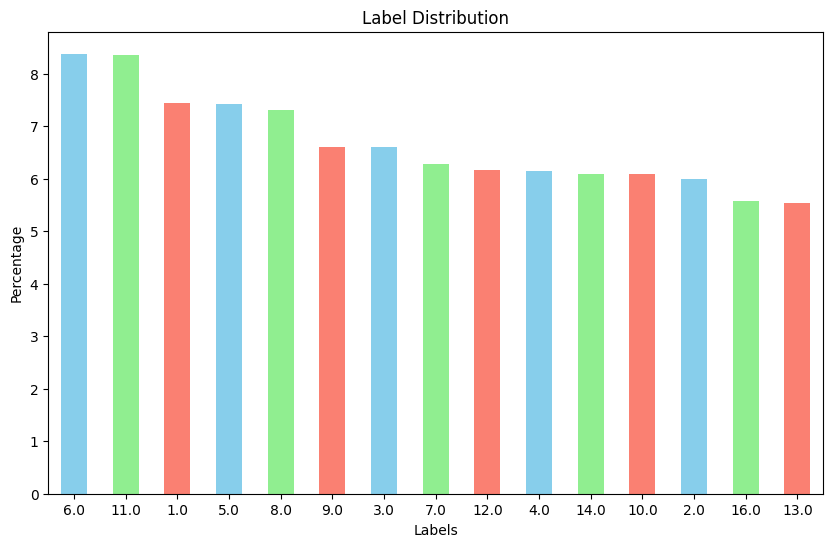

In [205]:
label_distribution = df['ID'].value_counts(normalize=True) * 100
print(label_distribution)

plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

7일의 데이터를 얻으려면 최소 2016개 이상의 5분 간격 데이터가 필요

In [206]:
df['ID'].value_counts()

ID
6.0     2557
11.0    2552
1.0     2271
5.0     2267
8.0     2231
9.0     2016
3.0     2013
7.0     1916
12.0    1880
4.0     1873
14.0    1859
10.0    1857
2.0     1829
16.0    1703
13.0    1688
Name: count, dtype: int64

In [207]:
for id in df['ID'].unique():
    print(f'ID: {id}')
    print(f"\tStart: {df[df['ID'] == id]['datetime'].iloc[0]}")
    print(f"\tEnd: {df[df['ID'] == id]['datetime'].iloc[-1]}")
    data_points = len(df[df['ID'] == id])
    points_per_day = (24 * 60) / 5
    days = data_points / points_per_day
    print(f'\tdays: {days}')


ID: 1.0
	Start: 2020-02-14 17:33:30
	End: 2020-02-22 17:53:23
	days: 7.885416666666667
ID: 2.0
	Start: 2020-02-22 11:18:34
	End: 2020-02-29 09:38:24
	days: 6.350694444444445
ID: 3.0
	Start: 2020-02-23 10:56:44
	End: 2020-03-01 11:36:31
	days: 6.989583333333333
ID: 4.0
	Start: 2020-02-28 11:06:19
	End: 2020-03-06 06:51:06
	days: 6.503472222222222
ID: 5.0
	Start: 2020-02-28 13:45:09
	End: 2020-03-07 11:46:05
	days: 7.871527777777778
ID: 6.0
	Start: 2020-02-29 12:28:11
	End: 2020-03-09 09:27:51
	days: 8.878472222222221
ID: 7.0
	Start: 2020-03-15 12:57:16
	End: 2020-03-22 11:06:57
	days: 6.652777777777778
ID: 8.0
	Start: 2020-03-15 14:19:50
	End: 2020-03-23 11:39:31
	days: 7.746527777777778
ID: 9.0
	Start: 2020-03-22 11:06:48
	End: 2020-03-29 11:01:41
	days: 7.0
ID: 10.0
	Start: 2020-03-23 11:39:16
	End: 2020-03-30 09:19:02
	days: 6.447916666666667
ID: 11.0
	Start: 2020-04-07 09:41:06
	End: 2020-04-16 07:20:51
	days: 8.86111111111111
ID: 12.0
	Start: 2020-05-04 18:07:12
	End: 2020-05-11 09

### 상관관계 Matrix Heat map

In [208]:
corrdf = df.drop(columns=['datetime']).corr()

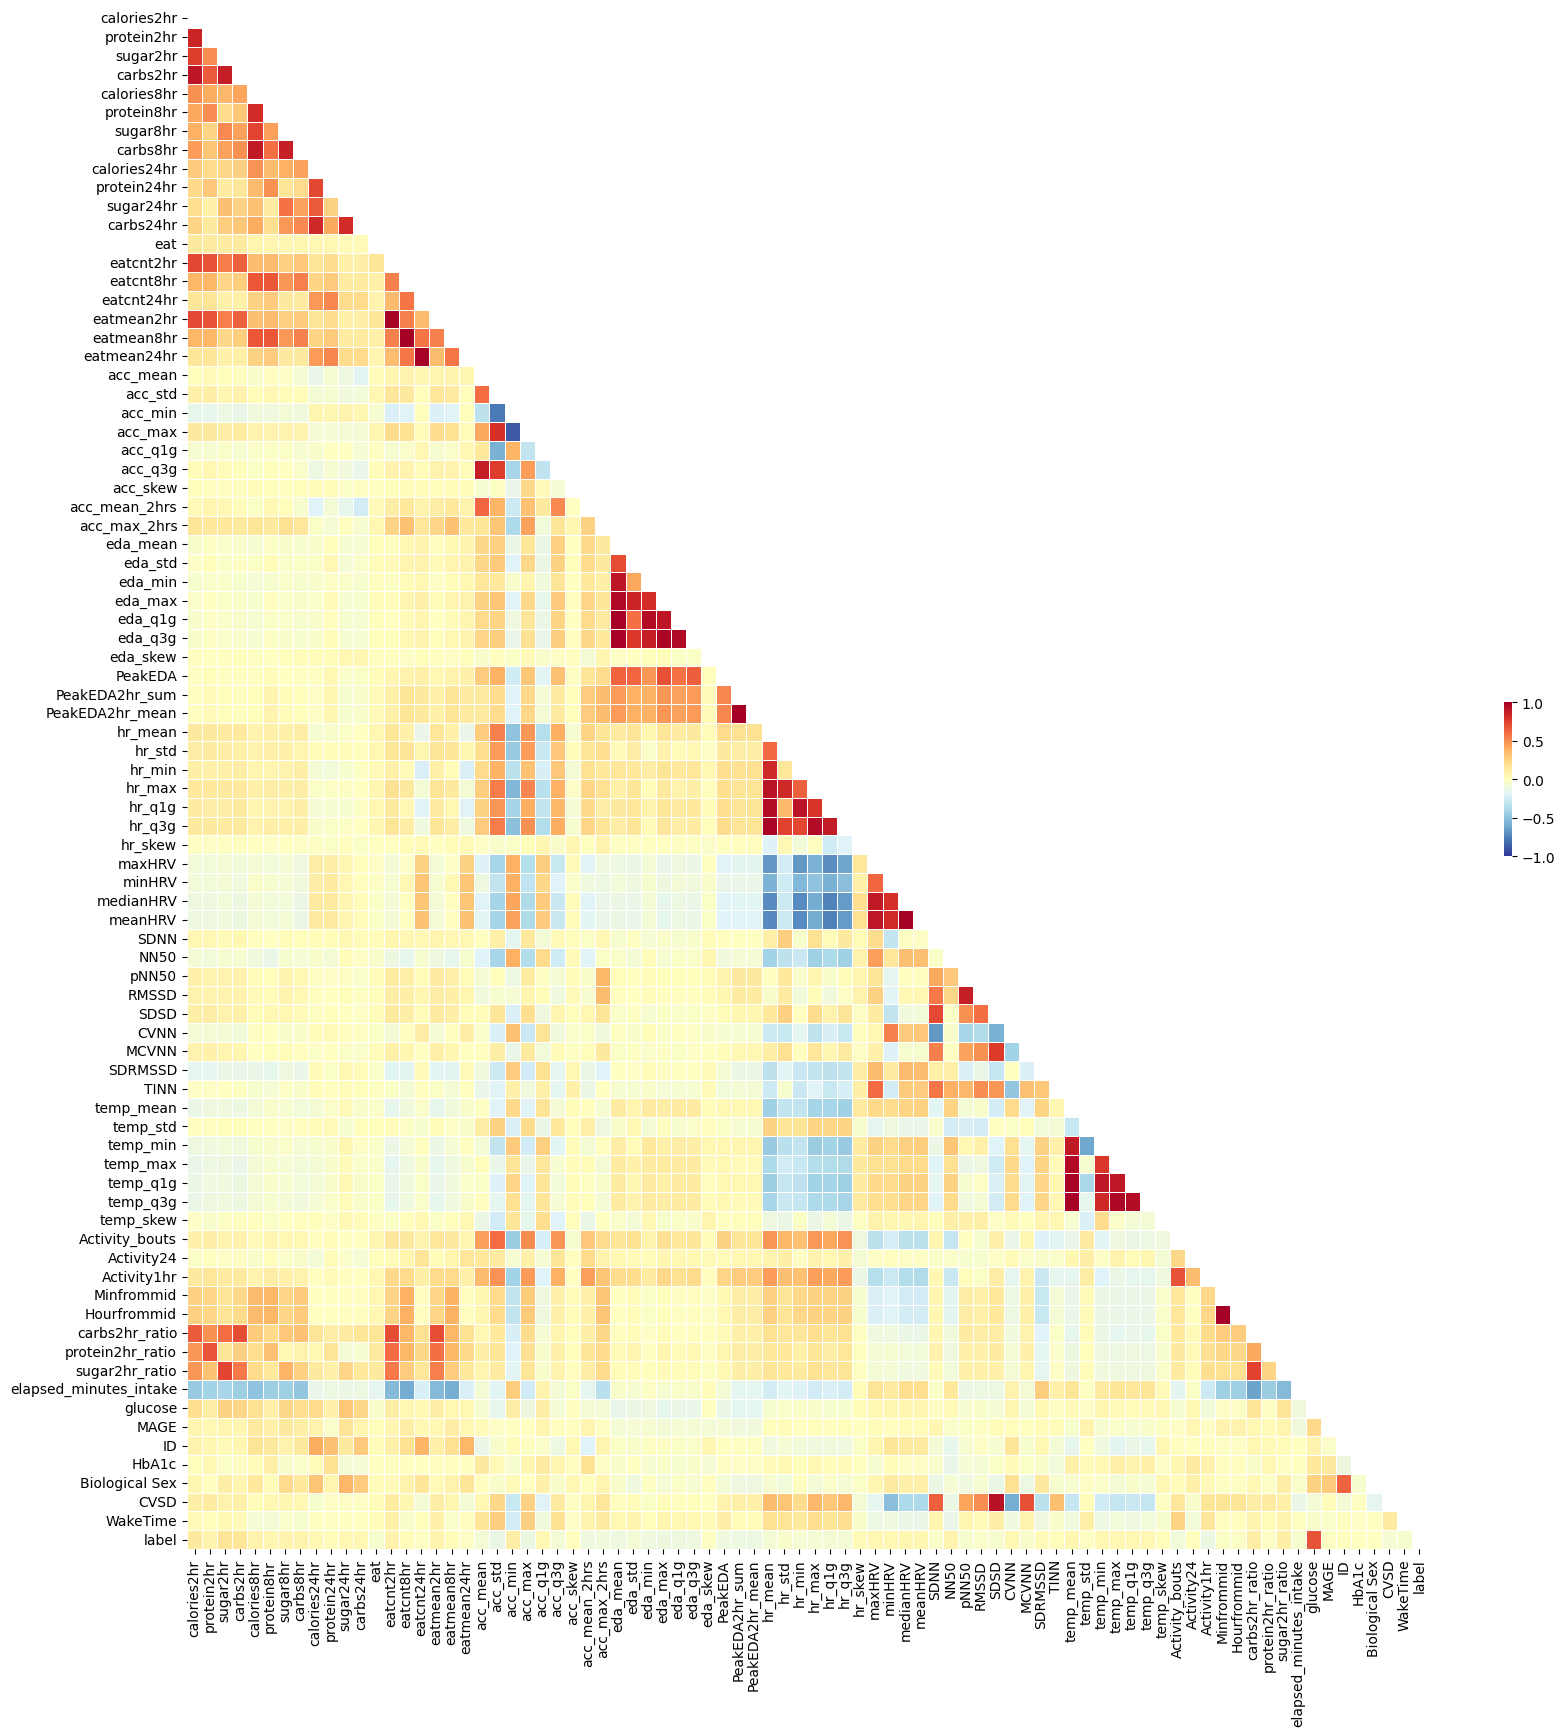

In [209]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()